# Collecting weather data

In [ ]:
import os
import subprocess
import zipfile
import csv
import fileinput
import pandas as pd
import shutil
import glob

# Collecting data from IMGW

In [ ]:
# Initializing variables
url = 'https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/dobowe/synop/'
raw_data_folder = '../imgw_data'
unzipped_folder = "../unzipped/"
output_csv = "../data.csv"

In [3]:
# Collecting latest data from IMGW website. Downloading only zip files missing from imgw_data folder.
if not os.path.exists(raw_data_folder):
    os.makedirs(raw_data_folder)

subprocess.call(['wget', '-r', '--no-parent', '--no-host-directories', '--cut-dirs=1',
                    '--directory-prefix=' + raw_data_folder, '-A', 'zip', '--no-clobber', url])

# Concatenating data about Tarnów from IMGW into single CSV

In [ ]:
# Unpacking all zip files
if not os.path.exists(unzipped_folder):
    os.mkdir(unzipped_folder)

for root, dirs, files in os.walk(raw_data_folder):
    for filename in files:
        filepath = os.path.join(root, filename)

        if zipfile.is_zipfile(filepath):
            with zipfile.ZipFile(filepath) as zip_file:
                zip_file.extractall(unzipped_folder)

In [ ]:
# Removing unnecessary files (containing redudant data about average values)
pattern = "s_d_t*"
files_to_delete = glob.glob(os.path.join(unzipped_folder, pattern))

for file_path in files_to_delete:
    os.remove(file_path)

In [ ]:
# Removing rows not containing station "Tarnów" from CSV files
for filename in os.listdir(unzipped_folder):
    if filename.endswith('.csv'):
        filepath = os.path.join(unzipped_folder, filename)
        with open(filepath, 'r', newline='', encoding="ANSI") as csvfile:
            reader = csv.reader(csvfile)
            rows_to_keep = [row for row in reader if row[1] == 'TARNÓW']
        with open(filepath, 'w', newline='', encoding="ANSI") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerows(rows_to_keep)

In [ ]:
# Removing remaining empty CSV files
for file_name in os.listdir(unzipped_folder):
    if file_name.endswith('.csv'):
        file_path = os.path.join(unzipped_folder, file_name)
        if os.path.getsize(file_path) == 0:
            os.remove(file_path)

In [ ]:
# Concatenating remaining CSV files
csv_files = [file for file in os.listdir(unzipped_folder) if file.endswith(".csv")]

with open(output_csv, "w", newline='') as outfile:
    writer = csv.writer(outfile)
    for file in csv_files:
        path = os.path.join(unzipped_folder, file)
        with open(path, "r", encoding="ANSI") as infile:
            reader = csv.reader(infile)
            for row in reader:
                writer.writerow(row)

In [ ]:
# Removing "unzipped" folder
shutil.rmtree('../unzipped')

# Preparing data

In [ ]:
# Sorting rows chronologically
with open(output_csv, 'r') as file:
    reader = csv.reader(file)
    sorted_rows = sorted(reader, key=lambda row: (int(row[2]), int(row[3]), int(row[4])))

with open(output_csv, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(sorted_rows)

In [ ]:
# Adding headers to data
headers = ['CODE', 'NAME', 'YEAR', 'MONTH', 'DAY', 'TMAX', 'TMAX_ST', 'TMIN', 'TMIN_ST', 
            'STD', 'STD_ST', 'TMNG', 'TMNG_ST', 'SMDB', 'SMDB_ST', 'RO', 'PKSN', 'PKSN_ST', 
            'RWSN', 'RWSN_ST', 'USL', 'USL_ST', 'DESZ', 'DESZ_ST', 'SNEG', 'SNEG_ST', 'DISN', 
            'DISN_ST', 'GRAD', 'GRAD_ST', 'MGLA', 'MGLA_ST', 'ZMGL', 'ZMGL_ST', 'SADZ', 
            'SADZ_ST', 'GOLO', 'GOLO_ST', 'ZMNI', 'ZMNI_ST', 'ZMWS', 'ZMWS_ST', 'ZMET', 
            'ZMET_ST', 'FF10', 'FF10_ST', 'FF15', 'FF15_ST', 'BRZA', 'BRZA_ST', 'ROSA', 
            'ROSA_ST', 'SZRO', 'SZRO_ST', 'DZPS', 'DZPS_ST', 'DZBL', 'DZBL_ST', 'SG', 
            'IZD', 'IZD_ST', 'IZG', 'IZG_ST', 'AKTN', 'AKTN_ST']

with open(output_csv, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    data = list(csv_reader)

with open(output_csv, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(headers)
    for row in data:
        csv_writer.writerow(row)

In [ ]:
# Removing columns containing information about station
with fileinput.input(files=output_csv, inplace=True) as f_input:
    csv_reader = csv.reader(f_input)

    for row in csv_reader:
        updated_row = row[2:]

        print(','.join(updated_row))

In [ ]:
# Converting date into YYYY-MM-DD format
df = pd.read_csv(output_csv, low_memory=False)
df["DATE"] = pd.to_datetime(df[["YEAR", "MONTH", "DAY"]])
df.drop(["YEAR", "MONTH", "DAY"], axis=1, inplace=True)
df = df[["DATE"] + [col for col in df.columns if col != "DATE"]]
df.to_csv(output_csv, index=False)

# Training and saving models

In [ ]:
import pandas as pd
from prophet import Prophet
import joblib

In [ ]:
data = pd.read_csv('../data.csv', low_memory=False)
data['DATE'] = pd.to_datetime(data['DATE'])

In [ ]:
data_min = data[['DATE', 'TMIN']]
data_max = data[['DATE', 'TMAX']]
data_pre = data[['DATE', 'SMDB']]

data_min.dropna(inplace=True)
data_max.dropna(inplace=True)
data_pre.dropna(inplace=True)

data_min.columns = ['ds', 'y']
data_max.columns = ['ds', 'y']
data_pre.columns = ['ds', 'y']

In [ ]:
model_min = Prophet()
model_max = Prophet()
model_pre = Prophet()

In [ ]:
model_min.fit(data_min)
model_max.fit(data_max)
model_pre.fit(data_pre)

In [ ]:
joblib.dump(model_min, '../models/model_min.joblib', compress=9)
joblib.dump(model_max, '../models/model_max.joblib', compress=9)
joblib.dump(model_pre, '../models/model_pre.joblib', compress=9)

# Making predictions

In [21]:
import joblib
import matplotlib.pyplot as plt

In [22]:
model_min = joblib.load('../models/model_min.joblib')
model_max = joblib.load('../models/model_max.joblib')
model_pre = joblib.load('../models/model_pre.joblib')

In [23]:
future_dates = model_min.make_future_dataframe(periods=30)  # Predict for 1 year from the last available date

In [24]:
forecast_min = model_min.predict(future_dates)
forecast_max = model_max.predict(future_dates)
forecast_precip = model_pre.predict(future_dates)

In [25]:
predicted_min = forecast_min[['ds', 'yhat']].tail(30)  # Last 365 rows for the minimum temperature
predicted_max = forecast_max[['ds', 'yhat']].tail(30)  # Last 365 rows for the maximum temperature
predicted_precip = forecast_precip[['ds', 'yhat']].tail(30)  # Last 365 rows for the precipitation

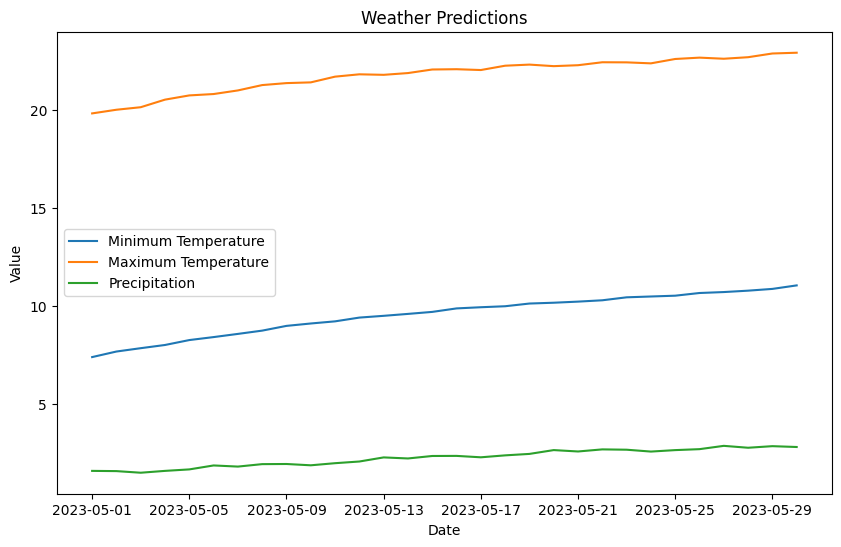

In [27]:
# Plotting the predictions
plt.figure(figsize=(10, 6))
plt.plot(predicted_min['ds'], predicted_min['yhat'], label='Minimum Temperature')
plt.plot(predicted_max['ds'], predicted_max['yhat'], label='Maximum Temperature')
plt.plot(predicted_precip['ds'], predicted_precip['yhat'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Weather Predictions')
plt.legend()
plt.show()